In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from kaggle_hm.config import train_dates, test_dates, data_root
from kaggle_hm.utils import init_nb, plot_item, visualize_items
import numpy as np
import json
from kaggle_hm.evaluation import compute_precision, enrich_data, plot_precision_at_k, plot_precision_at_k_segments, precision_by_age, precision_by_usage
from tqdm import tqdm

init_nb()

In [2]:
print(data_root)

/data/sstamenov/kaggle-data


Cosine similarity on items works nicely.
There are very few items with very high similarity >= .4. which are usually bought together.

Items with similarity >.1 provide reasonable similarity to customer's items and are OK to be recommended.
Items had to have at least 10 customers that bought both items to be considered a candidate.

Similarity rec. system looks at items that user bought in the past, finds all items that are similar to it and appends to the candidate list.
Then the list is sorted by similarity and first 12 items are returned. If there are not enough items, the rest is filled with top items.

KNN recs provide marginal improvement over top-12 or top-12 by age group category and reach 0.0041 on public leaderboard.
They provide more consistent precision over age groups, but provide worse precision for customers with high number of purchased items.

In [3]:
customers = pd.read_parquet(data_root / 'clean/customers.parquet').set_index('customer_id')
customers['age_group'] = pd.cut(customers['age'], bins=[16, 21, 26, 30, 40, 50, 60, 100])
items = pd.read_parquet(data_root / 'clean/articles.parquet')
t = pd.read_parquet(data_root / 'clean/transactions.parquet')

In [4]:
_ = (
    (t['t_dat'] >= test_dates['start']) &
    (t['t_dat'] <= test_dates['end'])
)
test = t[_]

In [5]:
customers.shape

(1371980, 7)

In [6]:
items.shape

(105542, 25)

In [7]:
t['customer_id'].nunique()

1362281

In [8]:
t['article_id'].nunique()

104547

In [9]:
from typing import List


def pad_rec(recommended: List, top_items):
    try:
        if np.isnan(recommended):
            recommended = []
    except:
        pass
    n = len(recommended)
    if n >= 12:
        return recommended
    while n < 12:
        if top_items[0] not in recommended:
            recommended.append(top_items[0])
        top_items.pop(0)
        n = len(recommended)
    return recommended

In [10]:
pad_rec([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [11]:
pad_rec([1, 2, 4], [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

[1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [20]:
similarity_df = pd.read_parquet(data_root / 'clean' / 'similarity_table.parquet').query('len_common >= 5')

In [21]:
similarity_df.head()

,simil,len_b,len_common,len_a,b,a
19,0.0381,246,5,70,0859424001,0878828002
22,0.1190,327,18,70,0878828001,0878828002
48,0.0444,181,5,70,0852374015,0878828002
81,0.0200,1287,6,70,0812668001,0878828002
7,0.0198,298,10,853,0762846001,0874891001


In [22]:
similarity_df.shape

(155872, 6)

# Knn predictions

In [24]:
_ = (
    (t['t_dat'] >= '2020-08-12') &
    (t['t_dat'] <= train_dates['end'])
)
train = t[_]

In [25]:
train.shape

(1069693, 5)

In [26]:
top12 = (
    train
    .groupby('article_id')
    .agg(total_count=('customer_id', 'count'))
    .sort_values('total_count', ascending=False).reset_index()[:24]['article_id'].tolist()
)

In [27]:
# ground truth
test_items = test.groupby('customer_id', observed=True).agg(bought=('article_id', set)).reset_index()

In [196]:
items

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,0108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,0108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,0108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,Dusty Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,0110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,4,Dark,5,Black,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,0110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,3,Light,9,White,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105537,0953450001,953450,5pk regular Placement1,302,Socks,Socks & Tights,1010014,Placement print,9,Black,4,Dark,5,Black,7188,Socks Bin,F,Menswear,3,Menswear,26,Men Underwear,1021,Socks and Tights,Socks in a fine-knit cotton blend with a small...
105538,0953763001,953763,SPORT Malaga tank,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1919,Jersey,A,Ladieswear,1,Ladieswear,2,H&M+,1005,Jersey Fancy,Loose-fitting sports vest top in ribbed fast-d...
105539,0956217002,956217,Cartwheel dress,265,Dress,Garment Full body,1010016,Solid,9,Black,4,Dark,5,Black,1641,Jersey,A,Ladieswear,1,Ladieswear,18,Womens Trend,1005,Jersey Fancy,"Short, A-line dress in jersey with a round nec..."
105540,0957375001,957375,CLAIRE HAIR CLAW,72,Hair clip,Accessories,1010016,Solid,9,Black,4,Dark,5,Black,3946,Small Accessories,D,Divided,2,Divided,52,Divided Accessories,1019,Accessories,Large plastic hair claw.


In [199]:
similarity_df['same_prod'] = similarity_df['a'].str[:7] == similarity_df['b'].str[:7]

In [203]:
def knn_candidates(data, similarity_df, max_candidates=12):
    nodup = data[['customer_id', 'article_id']].drop_duplicates()
    print('#item-customer pairs', nodup.shape)

    m = nodup.merge(similarity_df, left_on='article_id', right_on='a')
    print('#similar items', m.shape)

    # exclude rec items that customer already has
    _ = m.merge(nodup, left_on=['customer_id', 'b'], right_on=['customer_id', 'article_id'], how='outer')

    # deduplicate candidates
    # _ = _[_['article_id_y'].isna()].groupby(['customer_id', 'b'], observed=True).agg(simil=('simil', 'max'), len_common=('len_common', 'max'), cnt=('len_common', 'count')).reset_index()
    _ = _[_['article_id_y'].isna()]
    _['r'] = _.groupby(['customer_id', 'b'], observed=True)['len_common'].rank(method='first', ascending=False)
    _ = _[_['r'] == 1]
    print('#similar items excluding already bought', _.shape)
    _['r'] = _.groupby('customer_id')['len_common'].rank(method='first', ascending=False)

    # leave up to 12 most similar items
    candidates = _[_['r'] <= max_candidates]
    return candidates


def get_knn_recs(data, similarity_df, top12, test_items):
    candidates = knn_candidates(data, similarity_df)

    preds = candidates.sort_values(['customer_id', 'r']).groupby('customer_id',  observed=True).agg(recs=('b', list)).reset_index()

    preds['prediction'] = preds['recs'].apply(lambda recs: pad_rec(recs.copy(), top12.copy()))

    # test_items -> replace with submission
    results = test_items.merge(preds, on='customer_id', how='left')
    
    # fill cold-start users 
    f = results['prediction'].isna()
    results.loc[f, 'prediction'] = results.loc[f, 'prediction'].apply(lambda _: top12[:12])
    
    return results

In [165]:
results = get_knn_recs(train, similarity_df, top12, test_items).set_index('customer_id')

#item-customer pairs (949748, 2)
#similar items (63217060, 8)
#similar items excluding already bought (46259289, 5)


In [142]:
results = compute_precision(results)

In [33]:
(~results['recs'].isna()).sum(), results.shape[0]

(30940, 72019)

In [143]:
results['precision'].mean()

0.010615374289384692

In [35]:
cols = [f'rel_{i + 1}' for i in range(12)]

In [36]:
# first 1-2 places are good KNN candidates
pd.DataFrame({
    'total': results[cols].mean(),
    'knn': results[~results['recs'].isna()][cols].mean(),
    'total-s': results[cols].sum(),
    'knn-s': results[~results['recs'].isna()][cols].sum()
})

,total,knn,total-s,knn-s
rel_1,0.0120,0.0180,864,556
rel_2,0.0063,0.0135,454,418
rel_3,0.0078,0.0106,559,329
rel_4,0.0070,0.0090,501,279
rel_5,0.0068,0.0089,487,274
rel_6,0.0083,0.0084,596,260
rel_7,0.0055,0.0063,395,194
rel_8,0.0059,0.0065,424,202
rel_9,0.0038,0.0055,274,170
rel_10,0.0052,0.0052,373,161


In [67]:
test_sales = test.groupby('article_id').agg(test_cnt=('customer_id', 'count')).reset_index()
ext = test.merge(similarity_df, left_on='article_id', right_on='a', how='left')
sim_test = ext.groupby('article_id', observed=True).agg(simil=('simil', 'max'), len_common=('len_common', 'max')).reset_index().merge(test_sales, on='article_id')
item_sales = t[(t['t_dat'] <= train_dates['end'])].groupby('article_id', observed=True).agg(cnt=('customer_id', 'count'), min_dt=('t_dat', 'min'), max_dt=('t_dat', 'max')).reset_index()
sim_test = sim_test.merge(item_sales, on='article_id', how='left')

In [70]:
# similarity recall - out of 18.6k items, we have similarities for 7.3k items
sim_test[~sim_test['simil'].isna()].shape[0], sim_test.shape[0]

(7348, 18611)

In [73]:
# sales recall - out of 255k sold items, we recommended items that covered 191k (75%)
sim_test[~sim_test['simil'].isna()]['test_cnt'].sum(), sim_test['test_cnt'].sum()

(191944, 255241)

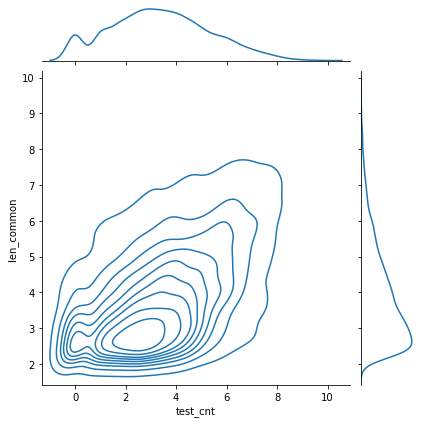

In [81]:
sns.jointplot(data=sim_test[~sim_test['simil'].isna()][['test_cnt', 'len_common']].apply(np.log2), x='test_cnt', y='len_common', kind='kde')

In [69]:
# items recall - out of 18.3k items sold in test period, we had 16.9k items sold in train period
np.intersect1d(test['article_id'].unique(), train['article_id'].unique()).size

16910

In [83]:
knn_results = results[~results['recs'].isna()]

In [93]:
knn_results[knn_results['rel_1']==1]['prediction'].str[0].value_counts().describe()

count   317.0000
mean      1.7539
std       1.9314
min       1.0000
25%       1.0000
50%       1.0000
75%       2.0000
max      16.0000
Name: prediction, dtype: float64

In [122]:
knn_results

,bought,recs,prediction,len_bought,rel_1,rel_2,rel_3,rel_4,rel_5,rel_6,rel_7,rel_8,rel_9,rel_10,rel_11,rel_12,rel_total,precision
customer_id,,,,,,,,,,,,,,,,,,
000fa1b80857fa40bf25990bc1b1b65afc63923a8e4b5762db34e4bb46032d29,"{0801673015, 0801673002, 0762143001, 074835501...","[0685813042, 0685813018, 0685814001, 068581300...","[0685813042, 0685813018, 0685814001, 068581300...",6,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000
00125440be6cd148c3599b9c5a2d55f5838c1b0257d35643038c38a60c691fe8,"{0610776002, 0827968022, 0723469002, 088288201...","[0572998009, 0448509014, 0714790020, 044850900...","[0572998009, 0448509014, 0714790020, 044850900...",6,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000
0018a4640de2338492de0fcc8325d6f6687d0c7980d804d8d8e4c5bfd24456d7,"{0920084004, 0935892001, 0936622001, 0909820001}","[0913688003, 0898918001, 0915453002, 089615200...","[0913688003, 0898918001, 0915453002, 089615200...",4,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000
001cae0f8d784913b4850af09f2c86ce09cdd177f49f8859ef373cebfd8d1594,{0710695015},"[0866731002, 0869331002, 0757303021, 085137000...","[0866731002, 0869331002, 0757303021, 085137000...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000
0036a44bd648ce2dbc32688a465b9628b7a78395302f26dd57b4ed75dce9b70c,"{0714790020, 0714790008, 0835348006}","[0863595004, 0893059004, 0863595002, 086359500...","[0863595004, 0893059004, 0863595002, 086359500...",3,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff264e809b8dc852b71512295eaaeea4bd480b1dc2cbb76b8b89693c4ca7ce8b,"{0717490057, 0723469001, 0717490079}","[0717490010, 0717490008, 0717490057, 068581304...","[0717490010, 0717490008, 0717490057, 068581304...",3,0,0,1,0,0,0,0,0,0,0,0,0,1,0.1111
ff26850309a635bbb242d968b948ef470876ccbacb387a2506459285691a59d6,{0850549001},"[0913688003, 0915453002, 0896152002, 090335900...","[0913688003, 0915453002, 0896152002, 090335900...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000
ffa213c087d31fcce6892a65e626bea96fb734e42e7847f923a7773e71ac687d,{0916256001},"[0915526002, 0639448001, 0920610002, 091646800...","[0915526002, 0639448001, 0920610002, 091646800...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000


In [97]:
results = enrich_data(train, results, customers)

In [114]:
pt = results.query('len_bought <= 12').pivot_table(
    index='len_bought',
    columns='rel_total',
    values='items_uniq',
    aggfunc='count'
)

pt

rel_total,0,1,2,3,4,5
len_bought,,,,,,
1,21802.0000,838.0000,NaN,NaN,NaN,NaN
2,16306.0000,1009.0000,72.0000,NaN,NaN,NaN
3,9980.0000,718.0000,59.0000,7.0000,NaN,NaN
4,6198.0000,520.0000,67.0000,4.0000,NaN,NaN
5,3949.0000,395.0000,36.0000,5.0000,NaN,NaN
6,2568.0000,276.0000,35.0000,7.0000,NaN,NaN
7,1713.0000,242.0000,17.0000,6.0000,NaN,NaN
8,1214.0000,172.0000,16.0000,3.0000,NaN,NaN
9,787.0000,122.0000,15.0000,2.0000,NaN,1.0000


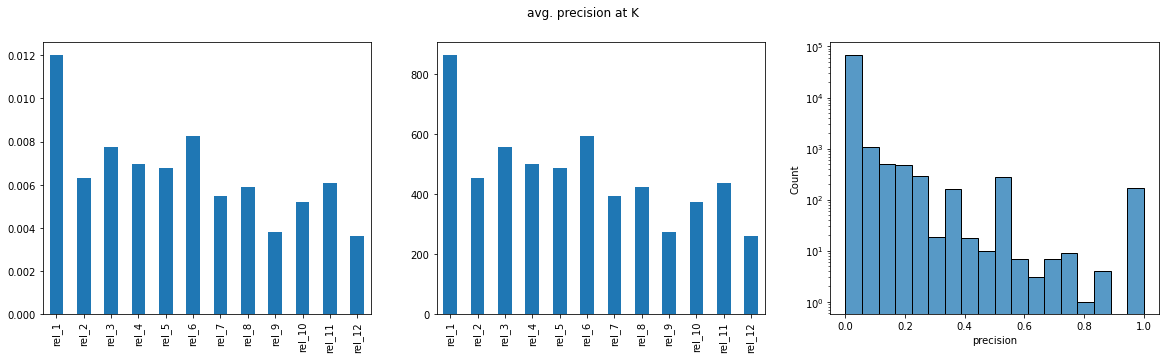

In [99]:
_ = plot_precision_at_k(results)

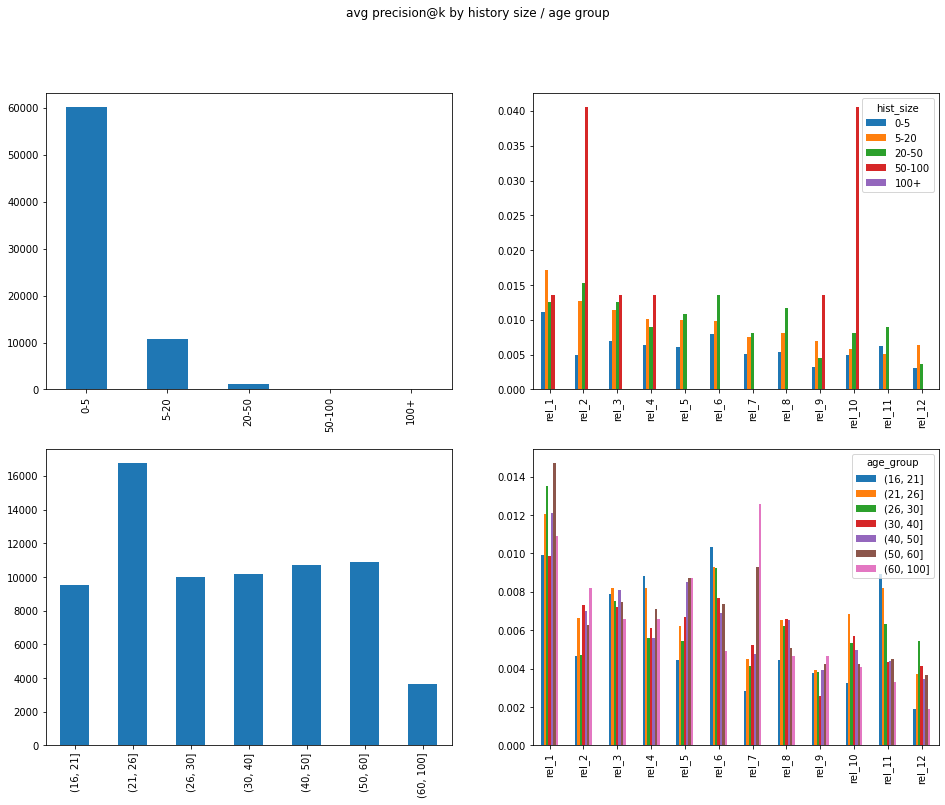

In [115]:
plot_precision_at_k_segments(results);

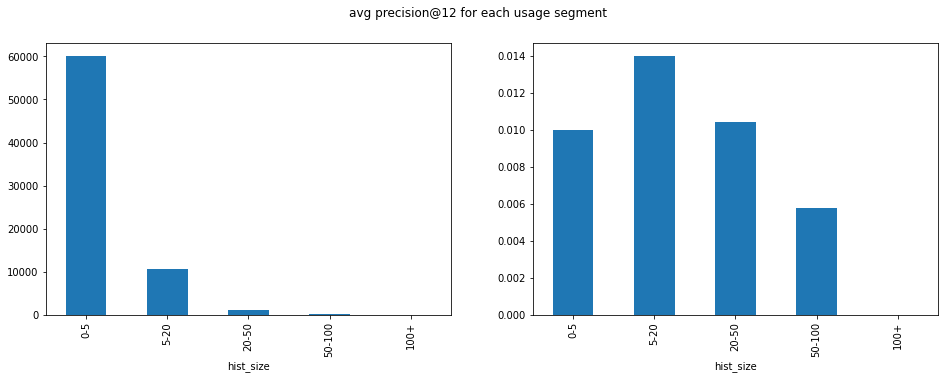

In [116]:
precision_by_usage(results);

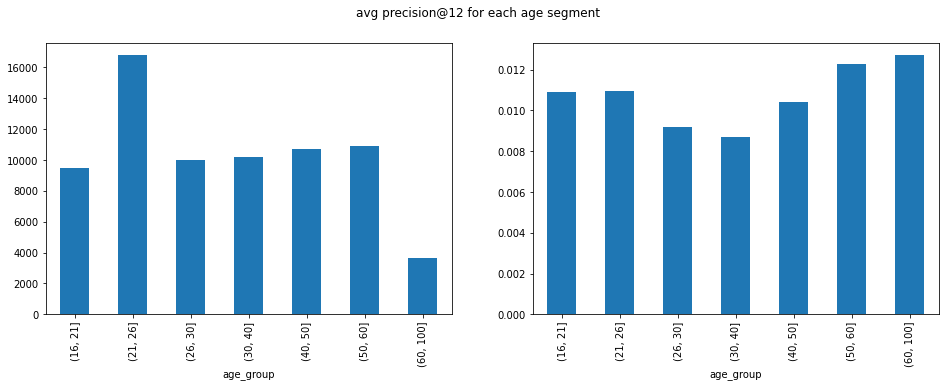

In [117]:
precision_by_age(results);

# test

In [204]:
possible_recs = knn_candidates(train, similarity_df)

#item-customer pairs (949748, 2)
#similar items (63217060, 9)
#similar items excluding already bought (46259289, 11)


In [206]:
possible_recs.head()

,customer_id,article_id_x,simil,len_b,len_common,len_a,b,a,same_prod,article_id_y,r
70,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0730683050,0.0636,1326.0000,89.0000,1479.0000,0852584001,0730683050,False,NaN,10.0000
96,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0730683050,0.0746,920.0000,87.0000,1479.0000,0905518001,0730683050,False,NaN,11.0000
160,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0730683050,0.0718,1062.0000,90.0000,1479.0000,0804992014,0730683050,False,NaN,9.0000
261,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0896152002,0.2092,1374.0000,337.0000,1889.0000,0896152001,0896152002,True,NaN,1.0000
284,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0896152002,0.1637,1294.0000,256.0000,1889.0000,0896152003,0896152002,True,NaN,2.0000


In [213]:
possible_recs[possible_recs['r'] == 1]['len_common'].describe()

count   220665.0000
mean        98.5629
std        101.2540
min          5.0000
25%         26.0000
50%         62.0000
75%        134.0000
max        609.0000
Name: len_common, dtype: float64

In [214]:
possible_recs[possible_recs['r'] == 1]['simil'].describe()

count   220665.0000
mean         0.1631
std          0.1202
min          0.0092
25%          0.0837
50%          0.1358
75%          0.2101
max          0.8715
Name: simil, dtype: float64

In [171]:
nodup = test[['customer_id', 'article_id']].drop_duplicates()

In [209]:
_ = nodup.merge(possible_recs, on='customer_id')

match = _[_['article_id'] == _['b']]

In [212]:
match['same_prod'].mean()

0.5551206784083497

In [215]:
pd.DataFrame({'global': match['len_common'].describe(), 'first-match': match[match['r'] == 1]['len_common'].describe()})

,global,first-match
count,3066.0000,561.0000
mean,62.6794,126.4456
std,68.6397,111.7096
min,5.0000,5.0000
25%,21.0000,43.0000
50%,42.0000,87.0000
75%,73.0000,174.0000
max,552.0000,552.0000


In [216]:
pd.DataFrame({'global': match['simil'].describe(), 'first-match': match[match['r'] == 1]['simil'].describe()})

,global,first-match
count,3066.0000,561.0000
mean,0.1082,0.1842
std,0.0867,0.1147
min,0.0057,0.0139
25%,0.0498,0.1119
50%,0.0889,0.1634
75%,0.1412,0.2180
max,0.7988,0.7988


In [219]:
match[match['r'] == 1]['same_prod'].mean()

0.7843137254901961

In [260]:
match[(~match['same_prod']) & (match['r'] == 1)].sample(n=10)

,customer_id,article_id,article_id_x,simil,len_b,len_common,len_a,b,a,same_prod,article_id_y,r
352616,8e7e14121dc059e846d013a80cc204191ef298579954c7...,0805000001,0740519002,0.0611,568.0000,26.0000,319.0000,0805000001,0740519002,False,NaN,1.0000
244025,0724ae9dae5237d08b80e9526b1c5ccf898bd4b699a867...,0552716001,0765308002,0.0176,742.0000,6.0000,157.0000,0552716001,0765308002,False,NaN,1.0000
184258,c6840cdabe5372bb22597ce743020644ac6b61a563e06f...,0896152002,0918516001,0.0521,1889.0000,50.0000,487.0000,0896152002,0918516001,False,NaN,1.0000
206895,ddfe13f4d0b201229f7d1601d1b932271745f89b3cdd87...,0871274002,0893420002,0.4758,132.0000,70.0000,164.0000,0871274002,0893420002,False,NaN,1.0000
660511,462845c6bed54cd9f3224964d9f9a2b1448397541df50d...,0868283001,0894956001,0.1396,695.0000,104.0000,798.0000,0868283001,0894956001,False,NaN,1.0000
837055,7a690aa6b7bfa0a9a2280a51aeace75b2c44277e060cbf...,0823168008,0879999001,0.6761,202.0000,130.0000,183.0000,0823168008,0879999001,False,NaN,1.0000
607803,f592da341c4ee6ca4a52f17c538dd568780de0d70ace2f...,0448509014,0714790020,0.0795,1456.0000,107.0000,1243.0000,0448509014,0714790020,False,NaN,1.0000
609869,f87851a3edda355dff4ff1a246ad1ed34d8188946848f6...,0816083001,0785787003,0.0805,149.0000,12.0000,149.0000,0816083001,0785787003,False,NaN,1.0000
487721,40d822b1fcb35a3ee61c9aefbdc4a8c10264f9e7586ace...,0751471001,0783346001,0.1012,2324.0000,175.0000,1286.0000,0751471001,0783346001,False,NaN,1.0000
367175,a1ce135a71b6833aad4fe6787e427d9fdec8b8ad4b794a...,0896064001,0903049003,0.4454,205.0000,124.0000,378.0000,0896064001,0903049003,False,NaN,1.0000


In [284]:
items[items['article_id'].isin(['0751471001', '0783346001'])]

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
67522,0751471001,751471,Pluto RW slacks (1),272,Trousers,Garment Lower body,1010016,Solid,9,Black,4,Dark,5,Black,1722,Trouser,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1009,Trousers,Ankle-length cigarette trousers in a stretch w...
75912,0783346001,783346,Primo slacks,272,Trousers,Garment Lower body,1010016,Solid,9,Black,4,Dark,5,Black,1722,Trouser,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1009,Trousers,Ankle-length cigarette trousers in a stretch w...


In [273]:
similarity_df[similarity_df['a'] == '0868283001'].sort_values('simil', ascending=False).head()

,simil,len_b,len_common,len_a,b,a,same_prod
284,0.1948,274,85,695,0868283004,0868283001,True
85,0.1773,534,108,695,0861803014,0868283001,False
398,0.1396,798,104,695,0894956001,0868283001,False
358,0.1337,142,42,695,0894680001,0868283001,False
762,0.1166,205,44,695,0876043001,0868283001,False


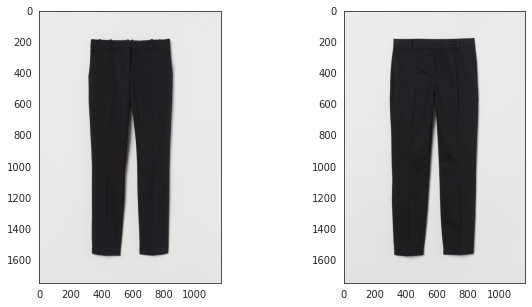

In [283]:
fig, ax = plt.subplots(1, 2)

plot_item('0751471001', ax=ax[0])
plot_item('0783346001', ax=ax[1])

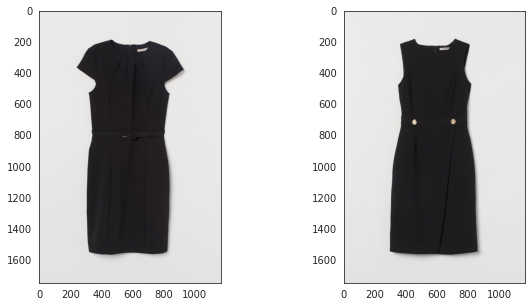

In [281]:
fig, ax = plt.subplots(1, 2)

plot_item('0816083001', ax=ax[0])
plot_item('0785787003', ax=ax[1])

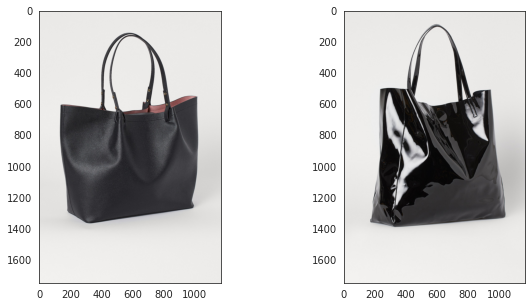

In [266]:
fig, ax = plt.subplots(1, 2)

plot_item('0552716001', ax=ax[0])
plot_item('0765308002', ax=ax[1])

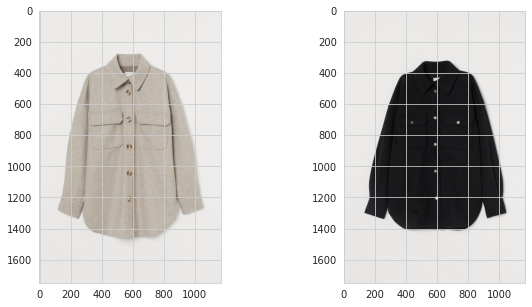

In [248]:
fig, ax = plt.subplots(1, 2)

plot_item('0898694001', ax=ax[0])
plot_item('0878190004', ax=ax[1])

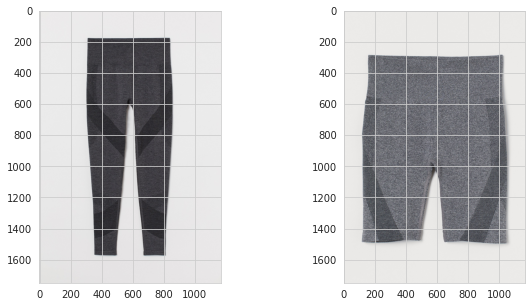

In [247]:
fig, ax = plt.subplots(1, 2)

plot_item('0918292001', ax=ax[0])
plot_item('0906729003', ax=ax[1])

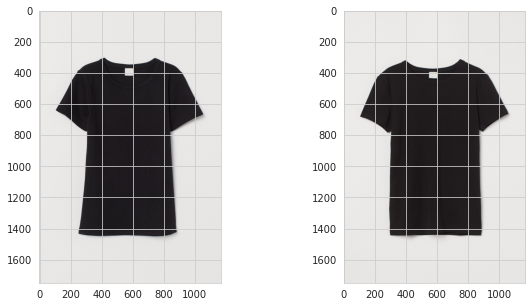

In [245]:
fig, ax = plt.subplots(1, 2)

plot_item('0800691008', ax=ax[0])
plot_item('0778064001', ax=ax[1])

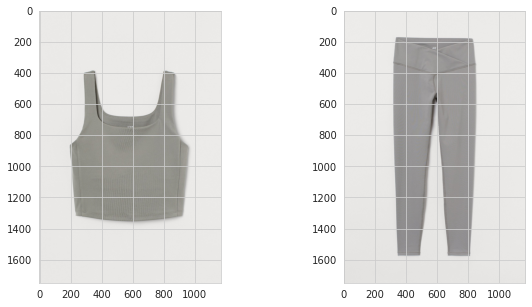

In [242]:
fig, ax = plt.subplots(1, 2)

plot_item('0894956006', ax=ax[0])
plot_item('0809961007', ax=ax[1])

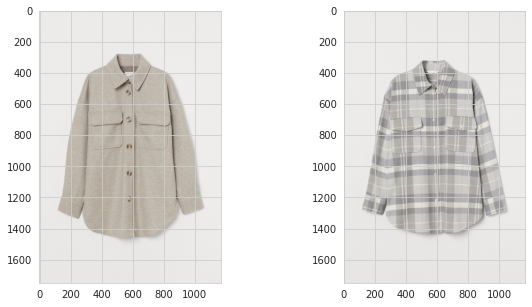

In [241]:
fig, ax = plt.subplots(1, 2)

plot_item('0898694001', ax=ax[0])
plot_item('0888343003', ax=ax[1])

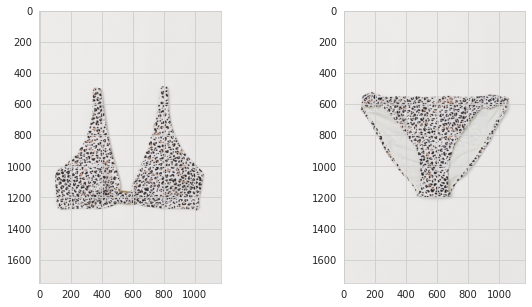

In [236]:
fig, ax = plt.subplots(1, 2)

plot_item('0811925005', ax=ax[0])
plot_item('0811927004', ax=ax[1])
# product_group_name = swimwear

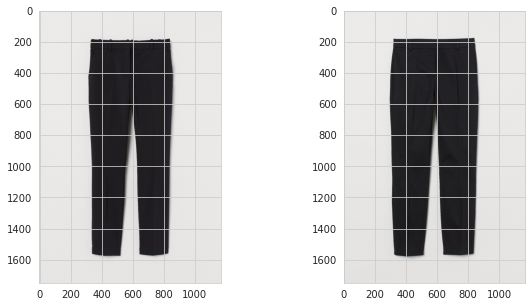

In [235]:
fig, ax = plt.subplots(1, 2)

plot_item('0751471001', ax=ax[0])
plot_item('0783346001', ax=ax[1])

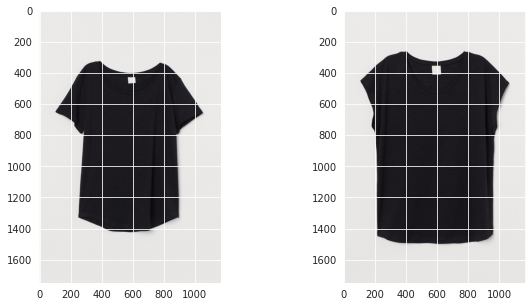

In [233]:
fig, ax = plt.subplots(1, 2)

plot_item('0554598001', ax=ax[0])
plot_item('0880008001', ax=ax[1])

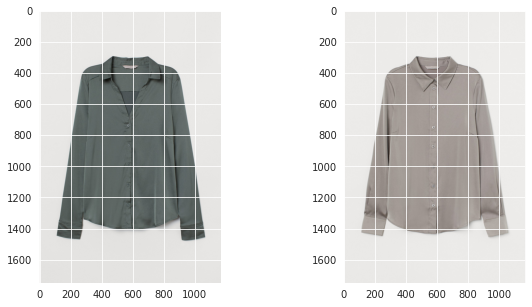

In [232]:
fig, ax = plt.subplots(1, 2)

plot_item('0762846031', ax=ax[0])
plot_item('0889460003', ax=ax[1])

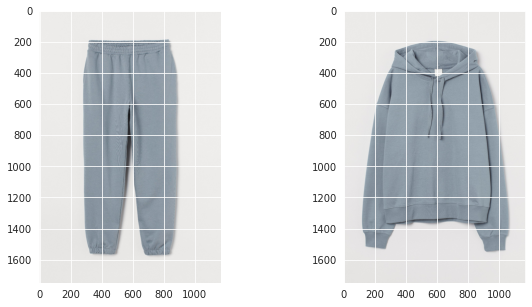

In [231]:
fig, ax = plt.subplots(1, 2)

plot_item('0909924002', ax=ax[0])
plot_item('0944506001', ax=ax[1])

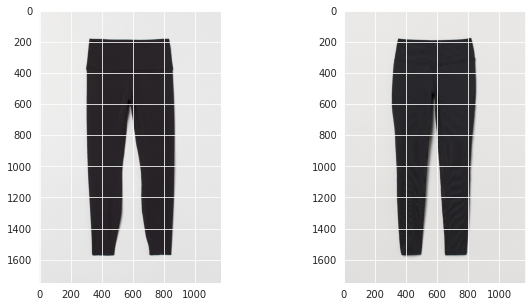

In [230]:
fig, ax = plt.subplots(1, 2)

plot_item('0907527001', ax=ax[0])
plot_item('0852584001', ax=ax[1])

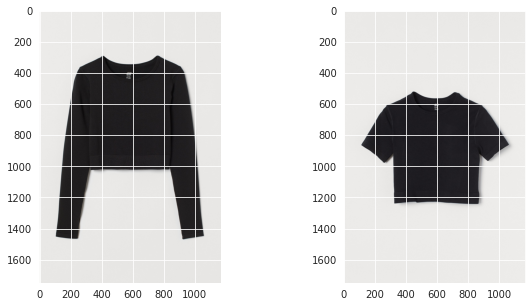

In [225]:
fig, ax = plt.subplots(1, 2)

plot_item('0924453003', ax=ax[0])
plot_item('0924605001', ax=ax[1])

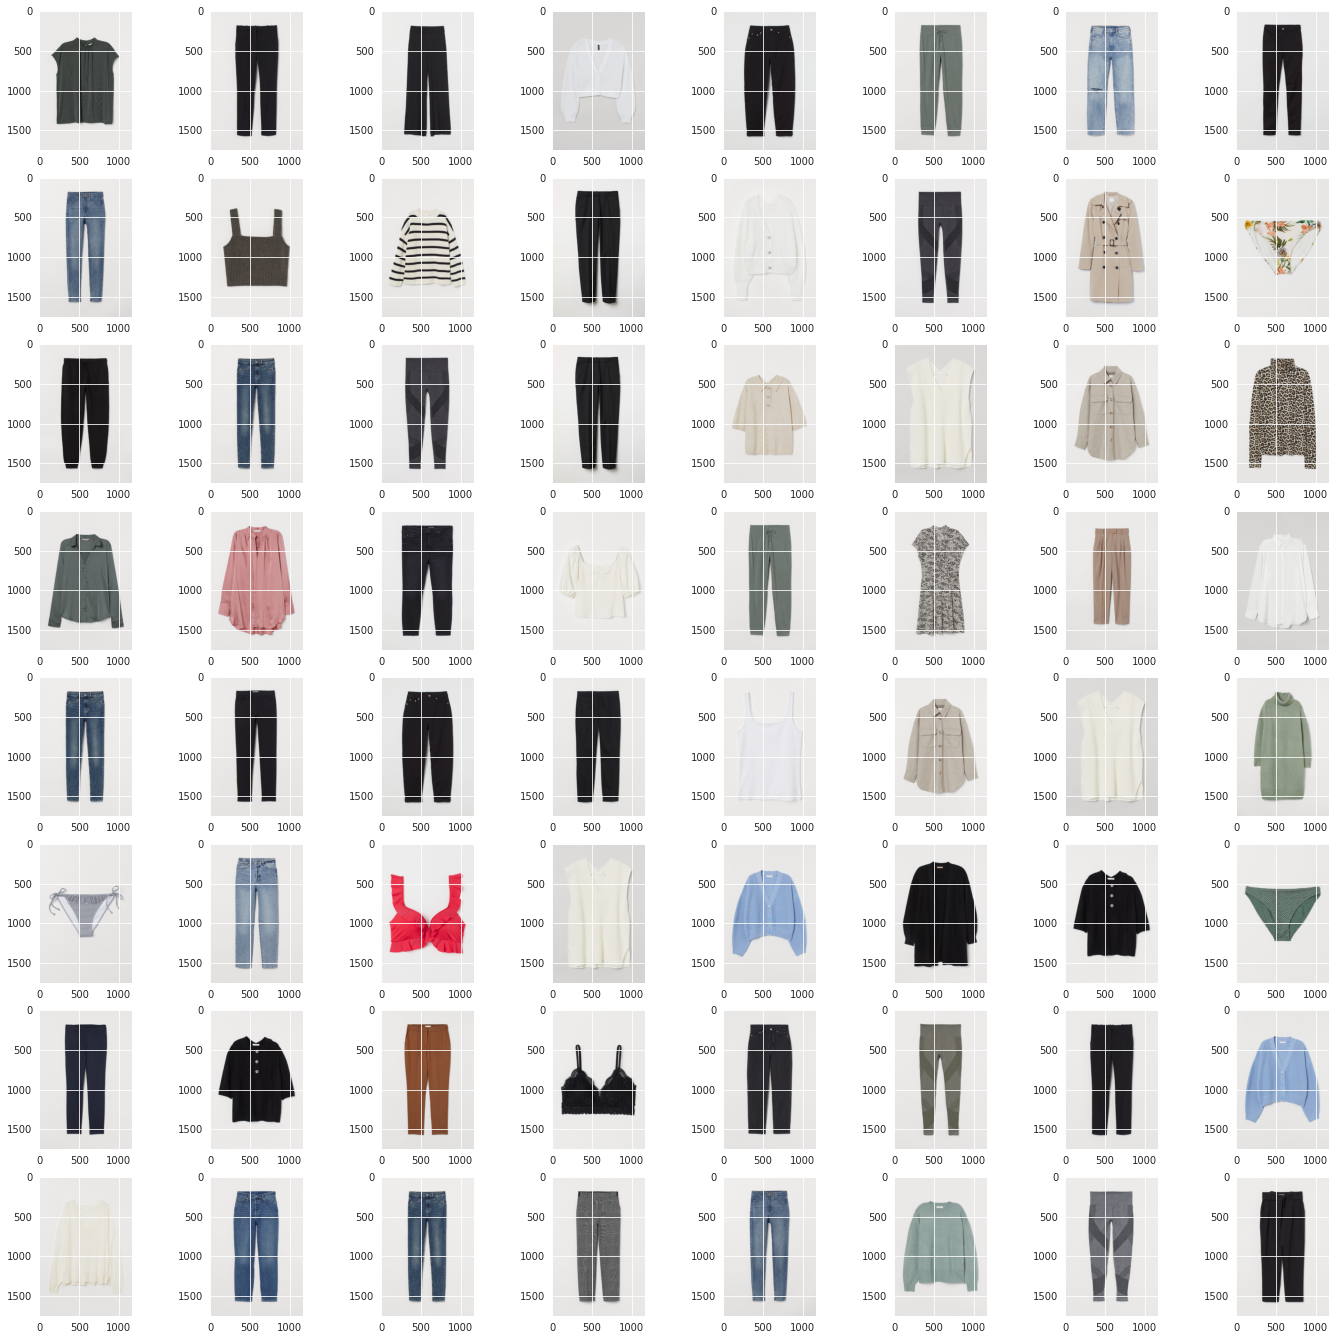

In [163]:
visualize_items(match[match['r'] == 1]['article_id'].sample(n=64))

In [ ]:
# why does it work? where does it work

In [159]:
match['r'].value_counts().sort_index()

0     556
1     413
2     328
3     277
4     267
5     253
6     186
7     197
8     161
9     150
10    133
11    144
Name: r, dtype: int64

In [160]:
match.shape[0] / nodup.shape[0]

0.013448290992058269

In [ ]:
# precision .8 / AUC ~.85 ?
# each customer 27k predictions, expected FPs

In [ ]:
# 7239 out of 222k sales LOL 3%

In [ ]:
item_stats = (
    t[t['t_dat'] <= train_dates['end']]
    .groupby('article_id', observed=True)
    .agg(
        total=('customer_id', 'count'),
        first_date=('t_dat', 'min'),
        last_date=('t_dat', 'max')
    )
)

In [ ]:
global_top12 = item_stats.sort_values('total', ascending=False)[:12].index.tolist()

In [ ]:
top12

In [ ]:
global_top12

In [ ]:
len(
    set(top12) & set(global_top12)
)

In [ ]:
test['hot'] = test['article_id'].isin(top12)
test['oldy'] = test['article_id'].isin(global_top12)

In [ ]:
test['hot'].mean() * 100

In [ ]:
test.drop_duplicates(subset=['customer_id', 'article_id'])['hot'].mean()

In [ ]:
test[test['hot']]

In [ ]:
test['oldy'].mean() * 100

In [ ]:
_ = test.groupby('article_id', observed=True).agg(test_count=('customer_id', 'count')).join(item_stats)

In [ ]:
_['d'] = pd.to_datetime('2020-09-15') - _['first_date']

In [ ]:
# unseen items
_[_['total'].isna()]['test_count'].sum()

In [ ]:
plot_item('0805947001')

In [ ]:
_.sort_values('test_count', ascending=False)[:20]

In [ ]:
_.sort_values('test_count', ascending=True)[:20]

In [ ]:
test.shape

# explore Knns

In [ ]:
_ = (
        (t['t_dat'] >= '2020-08-01') &
        (t['t_dat'] <= train_dates['end'])
)
train = t[_]
_ = (
        (t['t_dat'] >= test_dates['start']) &
        (t['t_dat'] <= test_dates['end'])
)
test = t[_]

In [ ]:
item_counts = train['article_id'].value_counts().reset_index()

item_counts = item_counts[item_counts['article_id'] > 1]

In [ ]:
row = item_counts.sample(n=1)

print(f"{row['index'].iloc[0]} - {row['article_id'].iloc[0]}")

item_id = row['index'].iloc[0]
s = get_similar_items([item_id])

s = s[s['len_common'] > 5]

In [ ]:
plot_item(item_id)

In [ ]:
s.sort_values('simil', ascending=False).reset_index()[:20]

In [ ]:
visualize_items(s.sort_values('simil', ascending=False).reset_index()['b'])

In [ ]:
recs = t.merge(similarity_df, left_on='article_id', right_on='a')

In [ ]:
cand_recs = recs.sort_values('simil', ascending=False).drop_duplicates(subset=['customer_id', 'b']).groupby('customer_id', observed=True).agg(top_k=('b', list)).reset_index()

# make submission

In [117]:
submission = pd.read_csv(data_root / 'sample_submission.csv')

In [268]:
similarity_df = pd.DataFrame()
for item_id in tqdm(os.listdir(data_root / 'clean' / 'pred_simil')):
    with open(data_root / 'clean' / 'pred_simil' / f'{item_id}') as f:
        data = json.load(f)
        if not data:
            continue
        _ = pd.DataFrame(data).query('len_common >= 5')  # todo param?
        similarity_df = pd.concat([similarity_df, _])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24623/24623 [05:28<00:00, 75.05it/s]


In [270]:
similarity_df.shape

(145842, 6)

In [271]:
_ = (
    (t['t_dat'] >= '2020-09-01')
)
train = t[_]
print(train.shape)
top12 = (
    train
    .groupby('article_id')
    .agg(total_count=('customer_id', 'count'))
    .sort_values('total_count', ascending=False)[:12].reset_index()['article_id'].tolist()
)
print(top12)
submission = get_knn_recs(train, similarity_df, top12, submission[['customer_id']])

(798269, 5)
['0751471001', '0909370001', '0918522001', '0924243001', '0918292001', '0915526001', '0915529003', '0448509014', '0751471043', '0706016001', '0865799006', '0863595006']
#item-customer pairs (705504, 2)
#similar items (57691313, 8)
#similar items excluding already bought (41059070, 4)


In [272]:
submission['recs'].isna().sum() / submission.shape[0]  # low coverage

0.8710454962900334

In [273]:
submission['prediction'] = submission['prediction'].apply(lambda _: ' '.join(_))

In [274]:
submission.head()

,customer_id,recs,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,"[0858856005, 0779781015, 0762846031, 056860100...",0858856005 0779781015 0762846031 0568601006 05...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,0751471001 0909370001 0918522001 0924243001 09...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"[0794321011, 0805000001, 0805000007, 080499201...",0794321011 0805000001 0805000007 0804992014 08...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,0751471001 0909370001 0918522001 0924243001 09...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,NaN,0751471001 0909370001 0918522001 0924243001 09...


In [275]:
submission.shape

(1371980, 3)

In [276]:
submission[['customer_id', 'prediction']].to_csv(data_root / 'output' / 'knn_submission.csv', index=False)